# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import MyFunctions.analysis_functions as analysis
import MyFunctions.hashing as hashing

# 1. Recommendation System with LSH

## 1.1 Data Preparation

### Main dataframe 

#### Loading

In [2]:
# Load the dataset for ratings and the one for movies
df_ratings = pd.read_csv("archive/rating.csv")
df_movies = pd.read_csv("archive/movie.csv")

# Creating main df for our analysis (for now)
main_df = pd.merge(df_ratings, df_movies, on="movieId")

#### Analysis

In [ ]:
# view shape of df
analysis.find_shape(main_df)

(20000263, 6)

In [4]:
 # check columns info and dtypes...
analysis.find_info(main_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [ ]:
# calculate statistical summary for numerical columns and summary for non numeric columns
analysis.find_desc(main_df)

(             userId       movieId        rating
 count  2.000026e+07  2.000026e+07  2.000026e+07
 mean   6.904587e+04  9.041567e+03  3.525529e+00
 std    4.003863e+04  1.978948e+04  1.051989e+00
 min    1.000000e+00  1.000000e+00  5.000000e-01
 25%    3.439500e+04  9.020000e+02  3.000000e+00
 50%    6.914100e+04  2.167000e+03  3.500000e+00
 75%    1.036370e+05  4.770000e+03  4.000000e+00
 max    1.384930e+05  1.312620e+05  5.000000e+00,
                   timestamp                title    genres
 count              20000263             20000263  20000263
 unique             15351121                26729      1329
 top     1996-03-01 00:00:00  Pulp Fiction (1994)     Drama
 freq                    643                67310   1467402)

In [ ]:
# check df for null values
analysis.find_null_vals(main_df)

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [6]:
# check df for duplicated rows
analysis.find_dup(main_df)

0

In [7]:
# Check the number of unique users and movies
print(f"Number of unique users: {main_df['userId'].nunique()}")
print(f"Number of unique movies: {main_df['movieId'].nunique()}")


Number of unique users: 138493
Number of unique movies: 26744


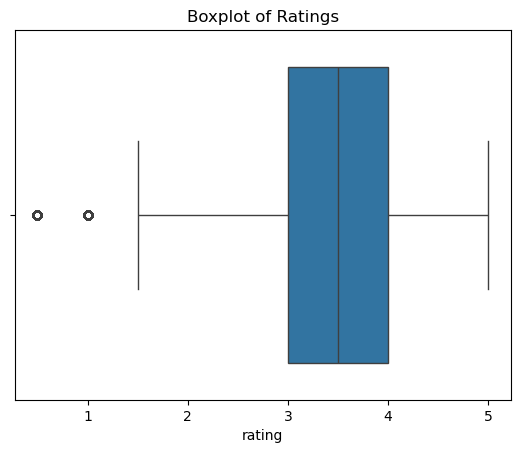

In [75]:
# check for outliers
sns.boxplot(x=main_df['rating'])
plt.title('Boxplot of Ratings')
plt.show()

# values around 1 are considered outliers, because probably not a lot of movies have a low rating


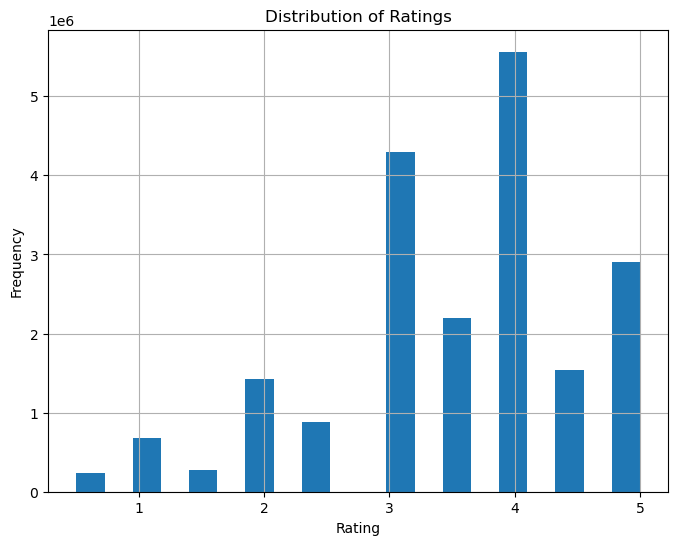

In [87]:
# Histogram to visualise the frequency of each rating score 
main_df['rating'].hist(bins=20, figsize=(8, 6))
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# understand what is the lowest rating given 
main_df['rating'].min()

0.5

In [77]:
# Check user activity (number of ratings per user)
user_activity = main_df['userId'].value_counts()
print(user_activity)

# Check movie popularity (number of ratings per movie)
movie_popularity = main_df['movieId'].value_counts()
print(movie_popularity)


userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
          ... 
89305       20
110463      20
96990       20
134747      20
6526        20
Name: count, Length: 138493, dtype: int64
movieId
296       67310
356       66172
318       63366
593       63299
480       59715
          ...  
125545        1
78873         1
112907        1
112909        1
110510        1
Name: count, Length: 26744, dtype: int64


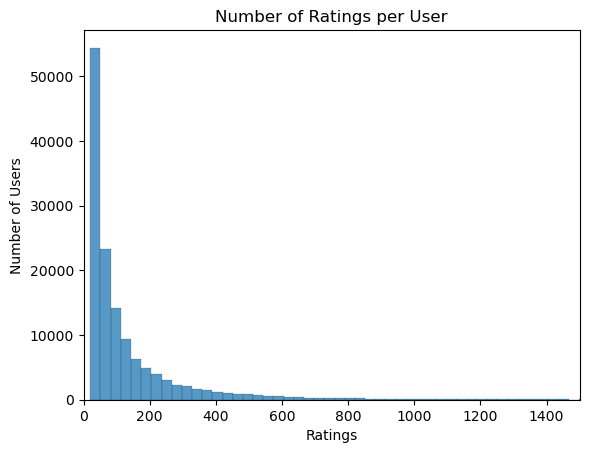

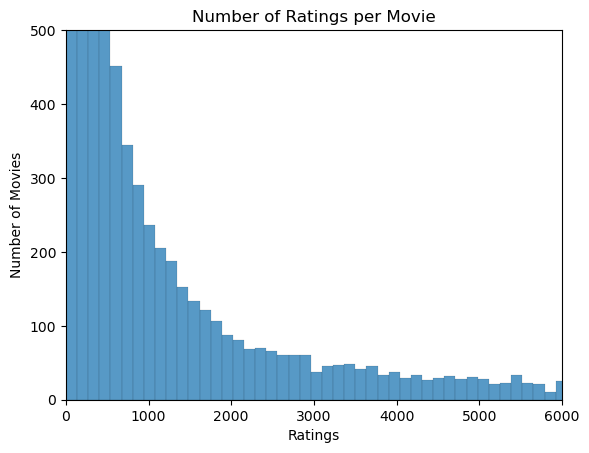

In [ ]:
# User activity visualised on graph
sns.histplot(user_activity, bins=300, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 1500)
plt.show()

# Movie popularity visualised on graph
sns.histplot(movie_popularity, bins=500, kde=False)
plt.title('Number of Ratings per Movie')
plt.xlabel('Ratings')
plt.ylabel('Number of Movies')
plt.xlim(0, 6000)
plt.ylim(0, 500)
plt.show()

In [10]:
# In the main_df description we can notice that drama is the top genre so we decide to dig a little deeper
drama_movies = main_df['genres'].str.contains('Drama')
display(main_df[drama_movies].head())
drama_movies.shape


,userId,movieId,rating,timestamp,title,genres
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
6,1,151,4.0,2004-09-10 03:08:54,Rob Roy (1995),Action|Drama|Romance|War
8,1,253,4.0,2005-04-02 23:35:40,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
10,1,293,4.0,2005-04-02 23:31:43,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
11,1,296,4.0,2005-04-02 23:32:47,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


(20000263,)

In [11]:
# Show the first 10 high rated movies
high_rated = main_df['rating']>4.0
main_df[high_rated].head(10)

,userId,movieId,rating,timestamp,title,genres
30,1,1196,4.5,2005-04-02 23:32:22,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
31,1,1198,4.5,2005-04-02 23:30:24,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
131,1,4993,5.0,2005-04-02 23:31:22,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
142,1,5952,5.0,2005-04-02 23:30:19,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
158,1,7153,5.0,2005-04-02 23:30:33,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
170,1,8507,5.0,2004-09-10 03:13:47,Freaks (1932),Crime|Drama|Horror
171,1,8636,4.5,2005-04-02 23:44:53,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX
176,2,62,5.0,2000-11-21 15:29:58,Mr. Holland's Opus (1995),Drama
177,2,70,5.0,2000-11-21 15:31:31,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
180,2,260,5.0,2000-11-21 15:36:54,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [ ]:
# show the top 10 most rated movies
most_rated = main_df.groupby('title').size().sort_values(ascending=False)[:10]
most_rated

title
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
dtype: int64

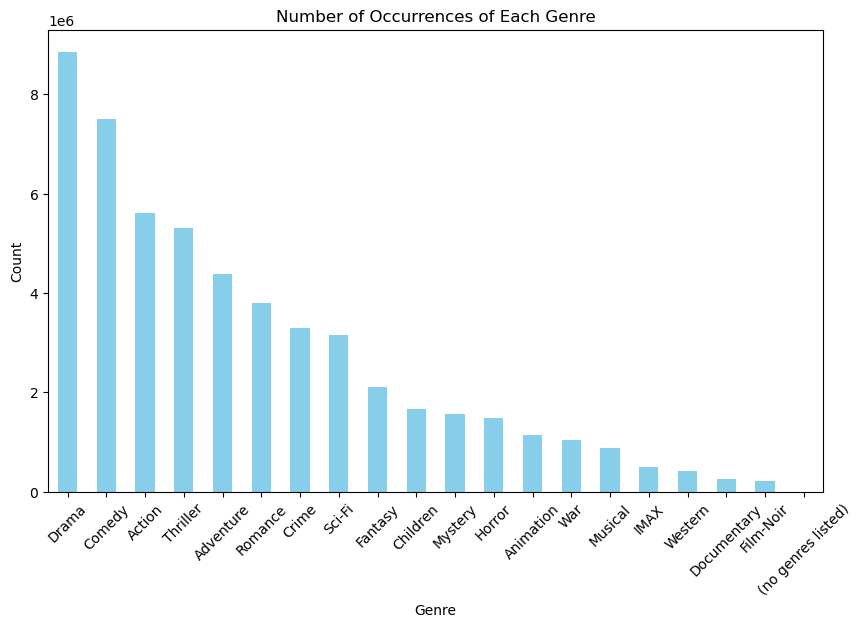

In [18]:
# Split the genres column and count occurrences
# Create a flat list of all genres
all_genres = main_df['genres'].str.split('|').explode()

# Count the occurrences of each genre
genre_counts = all_genres.value_counts()

# Visualize the counts using a bar chart
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Occurrences of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Handling timestamps

In [3]:
# Handle the timestamp column converting it to datetime
main_df['timestamp'] = pd.to_datetime(main_df['timestamp']) 
print(df_ratings['timestamp'].head())

# checking dtype of timestamp column changed
main_df.info()

# not needed it until now...
''' 
# Extract useful time-based features (e.g., year, month)
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second
print(df.head())
'''


0    2005-04-02 23:53:47
1    2005-04-02 23:31:16
2    2005-04-02 23:33:39
3    2005-04-02 23:32:07
4    2005-04-02 23:29:40
Name: timestamp, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
 4   title      object        
 5   genres     object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 915.5+ MB


" \n# Extract useful time-based features (e.g., year, month)\ndf['year'] = df['timestamp'].dt.year\ndf['month'] = df['timestamp'].dt.month\ndf['day_of_week'] = df['timestamp'].dt.dayofweek\ndf['day'] = df['timestamp'].dt.day\ndf['hour'] = df['timestamp'].dt.hour\ndf['minute'] = df['timestamp'].dt.minute\ndf['second'] = df['timestamp'].dt.second\nprint(df.head())\n"

### Other dataframes

#### Loading

In [2]:
# Load the rest of the dfs
all_dfs = []
df_genome_scores = pd.read_csv("archive/genome_scores.csv")
df_genome_tags = pd.read_csv("archive/genome_tags.csv")
df_links = pd.read_csv("archive/link.csv")
df_tags = pd.read_csv("archive/tag.csv")
all_dfs.append(("genome_scores", df_genome_scores))
all_dfs.append(("genome_tags", df_genome_tags))
all_dfs.append(("links", df_links))
all_dfs.append(("tags", df_tags))

#### Analysis

In [ ]:
# Analyse the rest of the df information
for df_name, dataframe in all_dfs:
    print("--------", df_name, "------------")
    print("--------- df shape")
    print(analysis.find_shape(dataframe))
    print("--------- df info")
    print(analysis.find_info(dataframe))
    print("--------- df description")
    print(analysis.find_desc(dataframe))
    print("--------- df null count")
    print(analysis.find_null_vals(dataframe))
    print("--------- df duplicate count")
    print(analysis.find_dup(dataframe))
    

-------- genome_scores ------------
--------- df shape
(11709768, 3)
--------- df info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB
None
--------- df description
            movieId         tagId     relevance
count  1.170977e+07  1.170977e+07  1.170977e+07
mean   2.584297e+04  5.645000e+02  1.164833e-01
std    3.467615e+04  3.256254e+02  1.542463e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    2.926000e+03  2.827500e+02  2.425000e-02
50%    6.017000e+03  5.645000e+02  5.650000e-02
75%    4.606200e+04  8.462500e+02  1.415000e-01
max    1.311700e+05  1.128000e+03  1.000000e+00
None
--------- df null count
movieId      0
tagId        0
relevance    0
dtype: int64
--------- df duplicate count
0
-------- genome_tags ------------
--------- df 

We notice that the links and tags df contains null values, so we handle it in this phase 

#### Cleaning

In [3]:
# We fill nan values with empty space in order not to lose any important information
df_links.fillna(" ")

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
27273,131254,466713,4436.0
27274,131256,277703,9274.0
27275,131258,3485166,285213.0
27276,131260,249110,32099.0


In [4]:
# We drop nan values because they are very few and this df only contains information on tags, 
# and if the tag is not present, the row doesnt make sense
df_tags.dropna()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465559,138446,55999,dragged,2013-01-23 23:29:32
465560,138446,55999,Jason Bateman,2013-01-23 23:29:38
465561,138446,55999,quirky,2013-01-23 23:29:38
465562,138446,55999,sad,2013-01-23 23:29:32


**Further analysis of these dfs can be added if needed later on in the project**

## 1.2 Minhash Signatures

In [4]:
# create a dictionary where the key is the userId and the value is the set of movieIds the user watched 
user_movies = main_df.groupby('userId')['movieId'].apply(set).to_dict()

In [5]:
minhash_simple_sig = hashing.minhash(user_movies, 2, hashing.simple_hash)
minhash_simple_sig

{1: [196, 241],
 2: [221, 170],
 3: [83, 25],
 4: [270, 280],
 5: [129, 93],
 6: [85, 41],
 7: [38, 189],
 8: [69, 123],
 9: [5922, 3075],
 10: [76, 111],
 11: [146, 82],
 12: [65, 74],
 13: [117, 45],
 14: [163, 183],
 15: [163, 158],
 16: [132, 136],
 17: [618, 491],
 18: [1284, 595],
 19: [14, 70],
 20: [374, 668],
 21: [493, 243],
 22: [103, 94],
 23: [101, 67],
 24: [62, 93],
 25: [106, 120],
 26: [246, 457],
 27: [321, 201],
 28: [2056, 475],
 29: [90, 23],
 30: [297, 390],
 31: [175, 169],
 32: [49, 194],
 33: [515, 2313],
 34: [85, 78],
 35: [390, 1297],
 36: [5160, 4697],
 37: [3272, 6415],
 38: [324, 90],
 39: [123, 43],
 40: [84, 1145],
 41: [142, 139],
 42: [947, 1144],
 43: [2411, 1495],
 44: [930, 2814],
 45: [5064, 9868],
 46: [131, 95],
 47: [85, 106],
 48: [461, 518],
 49: [2033, 1270],
 50: [1110, 575],
 51: [530, 1277],
 52: [227, 120],
 53: [139, 68],
 54: [134, 60],
 55: [878, 2015],
 56: [294, 560],
 57: [2500, 906],
 58: [93, 141],
 59: [52, 77],
 60: [669, 2137]

In [6]:
minhash_poly_sig = hashing.minhash(user_movies, 2, hashing.polynomial_hash)
minhash_poly_sig

{1: [254, 45],
 2: [255, 240],
 3: [44, 71],
 4: [168, 221],
 5: [44, 122],
 6: [123, 111],
 7: [115, 98],
 8: [41, 85],
 9: [129644, 131439],
 10: [73, 114],
 11: [105, 62],
 12: [145, 133],
 13: [162, 95],
 14: [121, 67],
 15: [135, 503],
 16: [128, 48],
 17: [142, 448],
 18: [11885, 19501],
 19: [165, 94],
 20: [603, 1404],
 21: [570, 159],
 22: [90, 59],
 23: [43, 27],
 24: [185, 72],
 25: [778, 1042],
 26: [528, 780],
 27: [947, 264],
 28: [24962, 32109],
 29: [59, 209],
 30: [543, 268],
 31: [113, 88],
 32: [499, 274],
 33: [24884, 33251],
 34: [157, 176],
 35: [2982, 5548],
 36: [32868, 34839],
 37: [1118330, 1177508],
 38: [191, 267],
 39: [116, 135],
 40: [246, 360],
 41: [143, 319],
 42: [2332, 3928],
 43: [3290, 1642],
 44: [84822, 19262],
 45: [126322, 108535],
 46: [353, 173],
 47: [52, 111],
 48: [488, 191],
 49: [4551, 3784],
 50: [2667, 2493],
 51: [509, 862],
 52: [1897, 898],
 53: [145, 70],
 54: [84, 41],
 55: [19369, 22622],
 56: [336, 1117],
 57: [1211, 2030],
 58:

In [7]:
minhash_mult_sig = hashing.minhash(user_movies, 2, hashing.multiplicative_hash)
minhash_mult_sig

{1: [154, 96],
 2: [246, 213],
 3: [89, 65],
 4: [329, 330],
 5: [104, 52],
 6: [36, 6],
 7: [117, 51],
 8: [42, 30],
 9: [7832, 2683],
 10: [87, 39],
 11: [98, 57],
 12: [32, 75],
 13: [98, 36],
 14: [9, 24],
 15: [100, 17],
 16: [19, 75],
 17: [312, 462],
 18: [1201, 1955],
 19: [47, 6],
 20: [1064, 112],
 21: [594, 30],
 22: [62, 26],
 23: [80, 85],
 24: [84, 13],
 25: [96, 320],
 26: [84, 340],
 27: [264, 946],
 28: [392, 1168],
 29: [6, 184],
 30: [365, 480],
 31: [32, 70],
 32: [98, 119],
 33: [6210, 785],
 34: [10, 94],
 35: [50, 960],
 36: [2286, 4785],
 37: [11151, 21788],
 38: [80, 285],
 39: [85, 11],
 40: [341, 396],
 41: [224, 20],
 42: [1201, 444],
 43: [1839, 1820],
 44: [1716, 3594],
 45: [636, 6260],
 46: [205, 120],
 47: [78, 24],
 48: [114, 132],
 49: [650, 1000],
 50: [141, 1092],
 51: [141, 152],
 52: [912, 399],
 53: [37, 37],
 54: [2, 42],
 55: [8140, 220],
 56: [154, 625],
 57: [1426, 1457],
 58: [48, 50],
 59: [23, 18],
 60: [1209, 1054],
 61: [62, 144],
 62: [